C:\Users\rnd\AppData\Local\Temp\ipykernel_14052\4179557639.py:16: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(canvas.tostring_rgb(), dtype="uint8")
c:\Users\rnd\Envs\thesis\Lib\site-packages\pennylane\drawer\mpldrawer.py:275: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self._fig = plt.figure(figsize=figsize)
C:\Users\rnd\AppData\Local\Temp\ipykernel_14052\4179557639.py:16: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(canvas.tostring_rgb(), dtype="uint8")


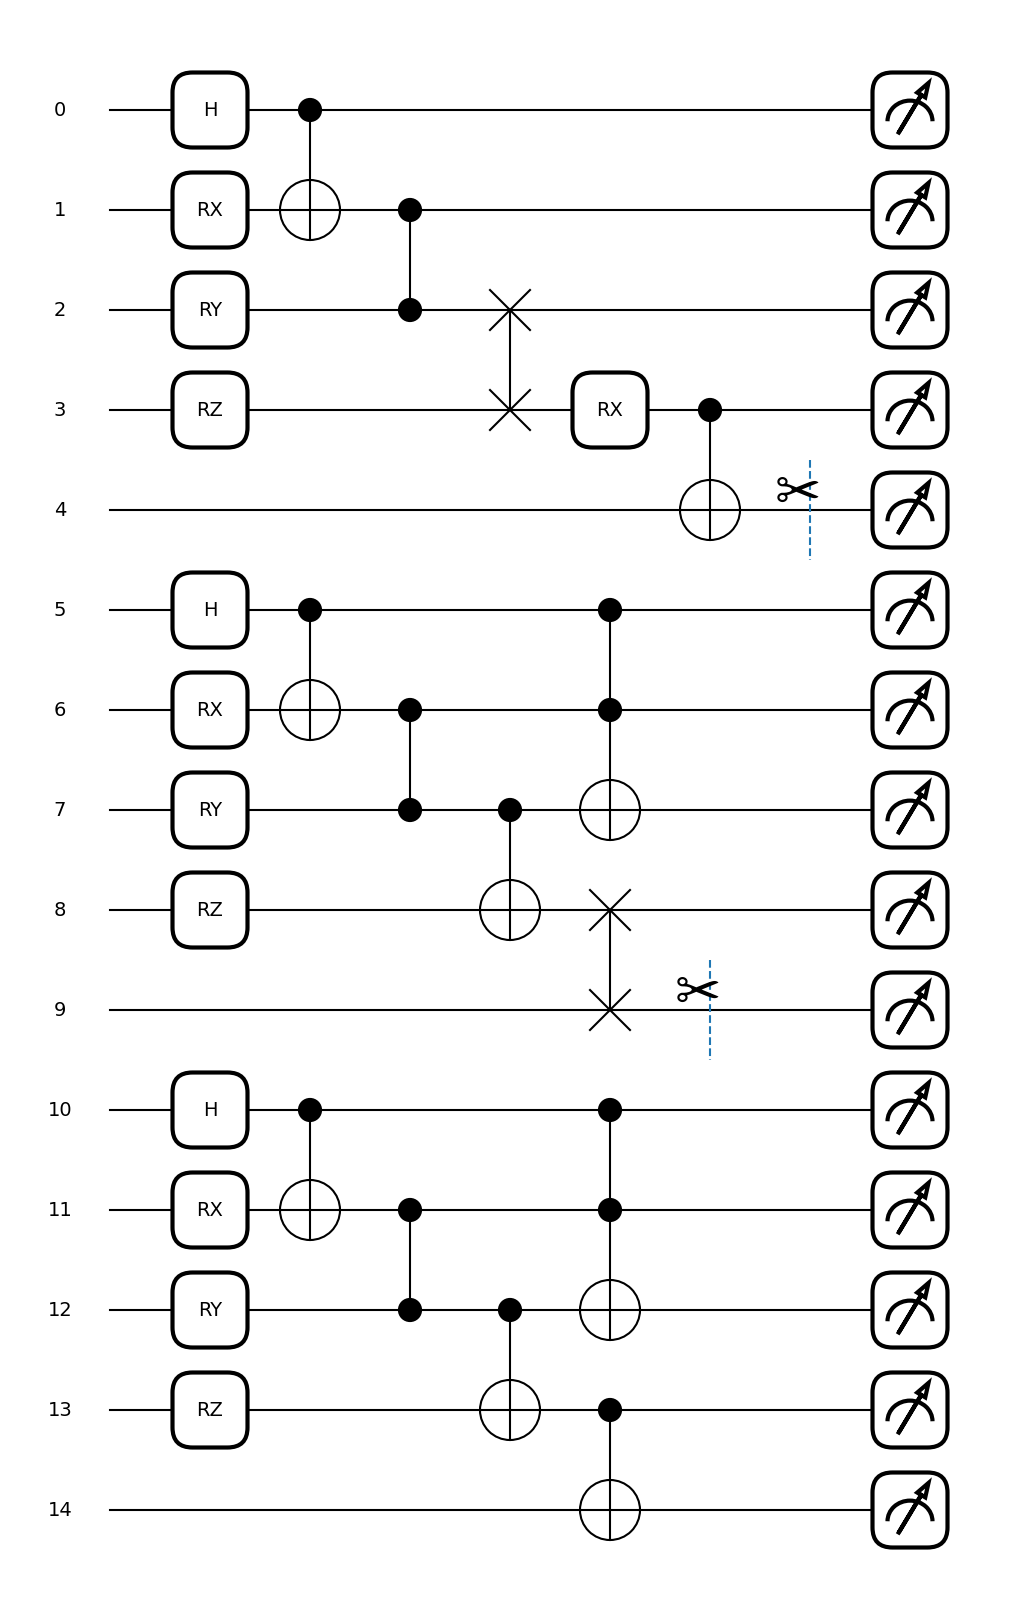

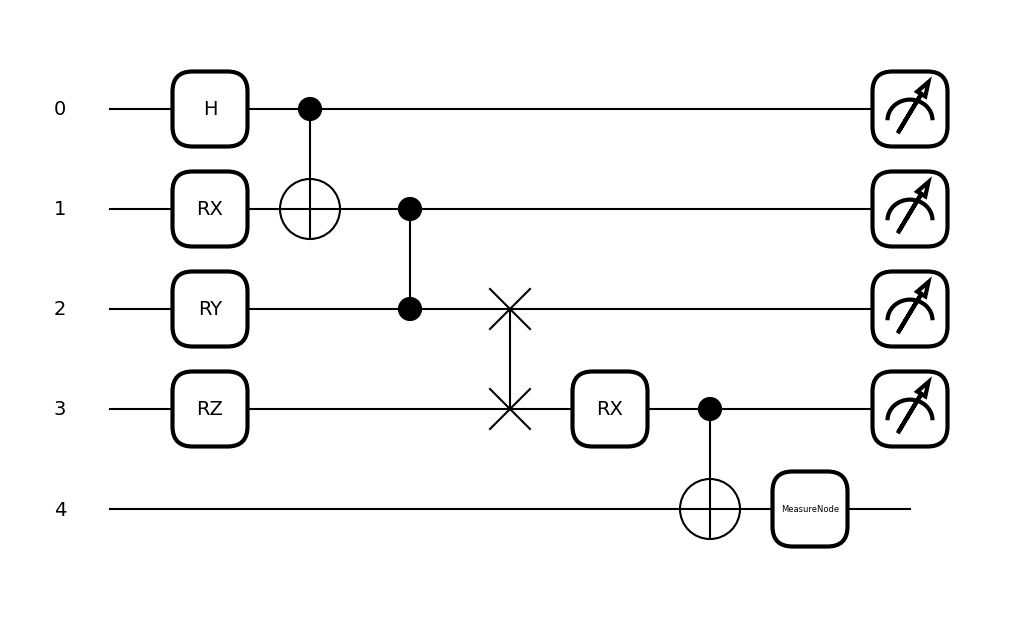

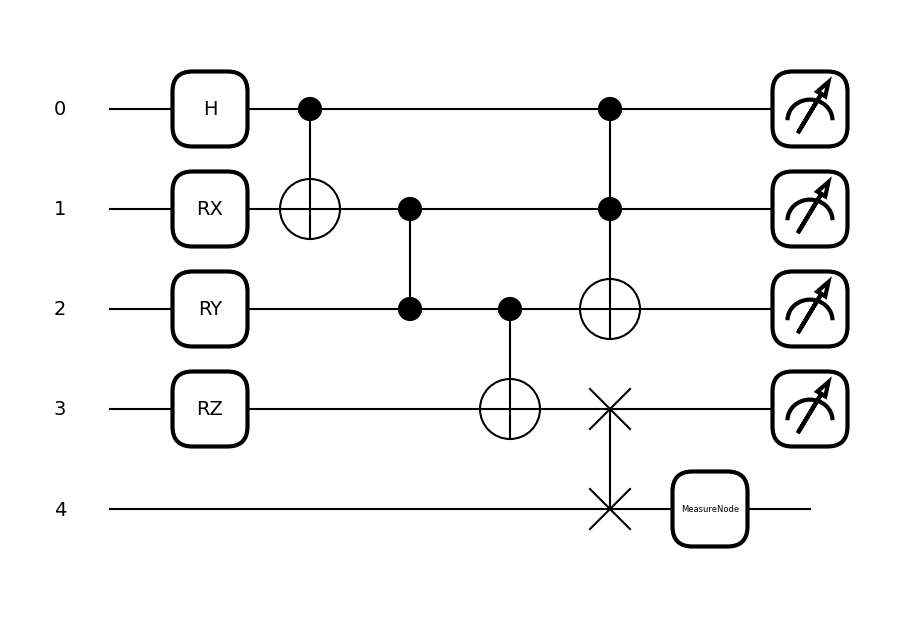

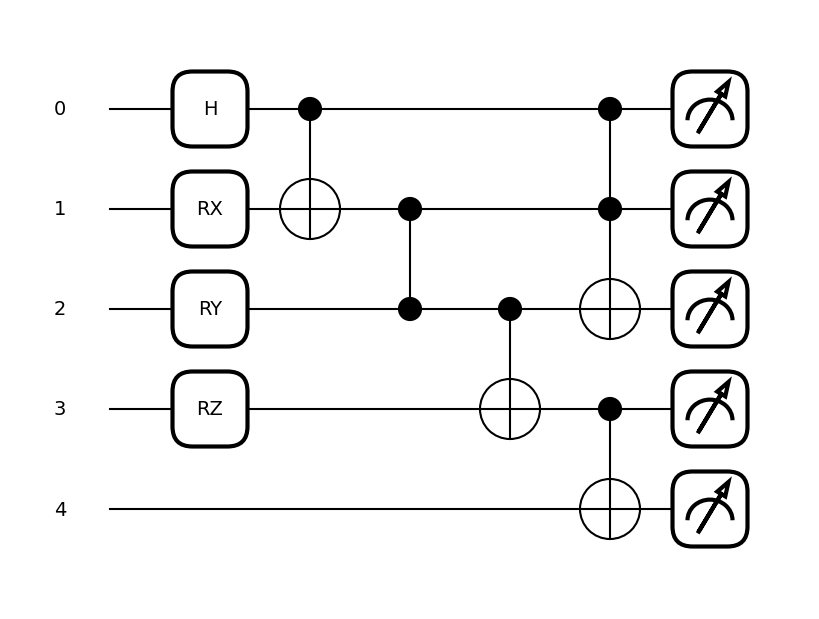

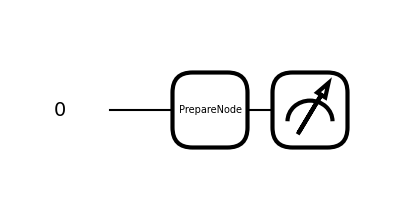

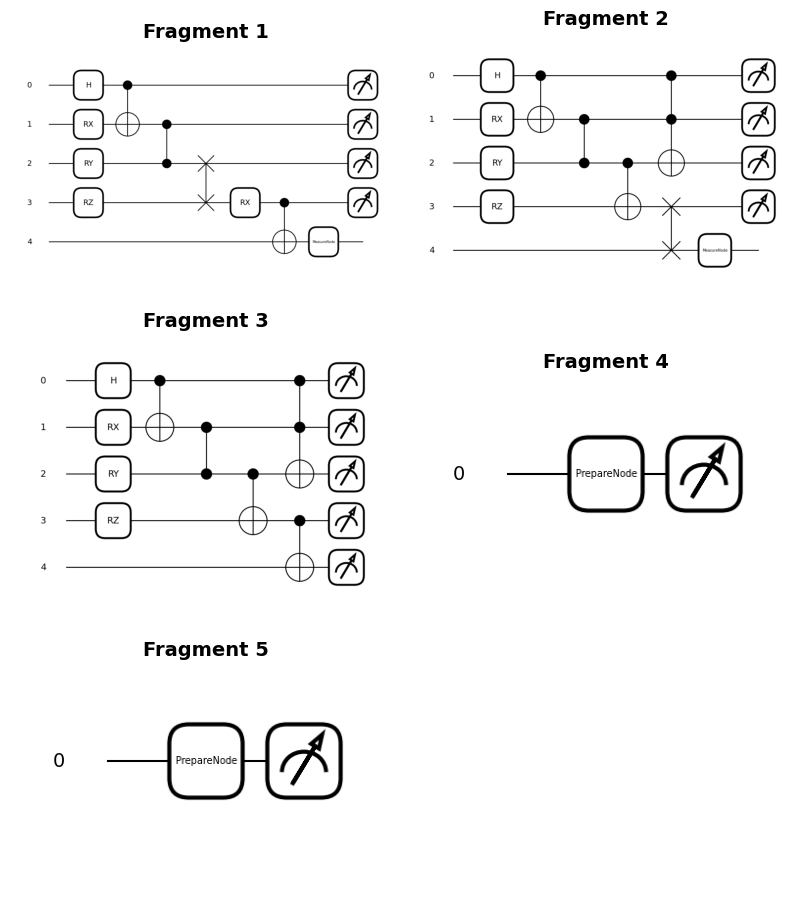

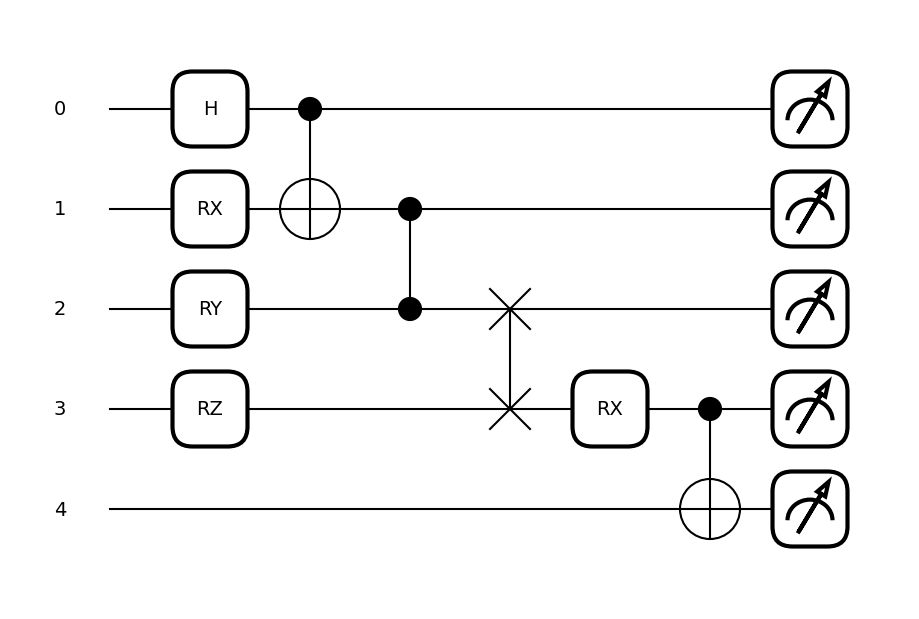

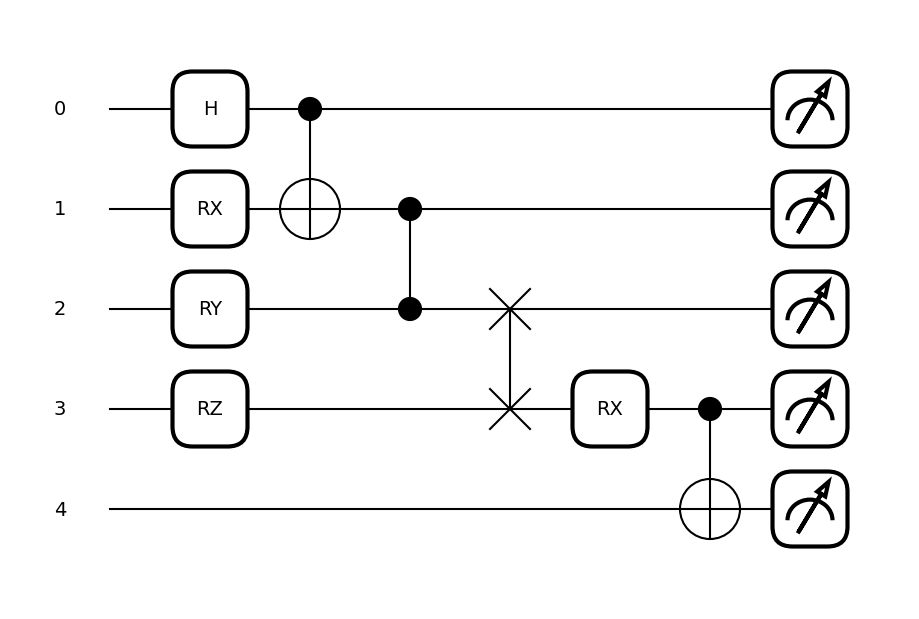

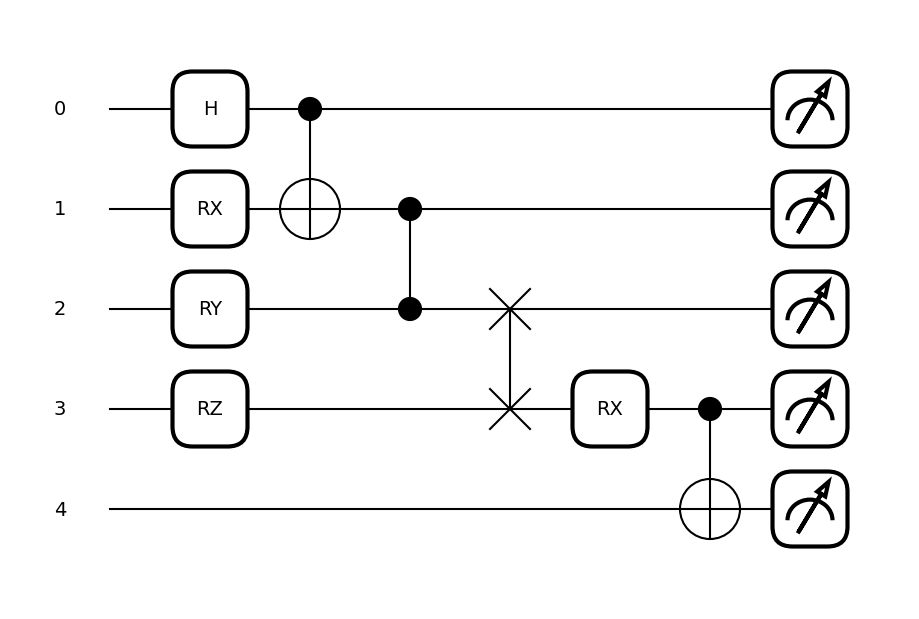

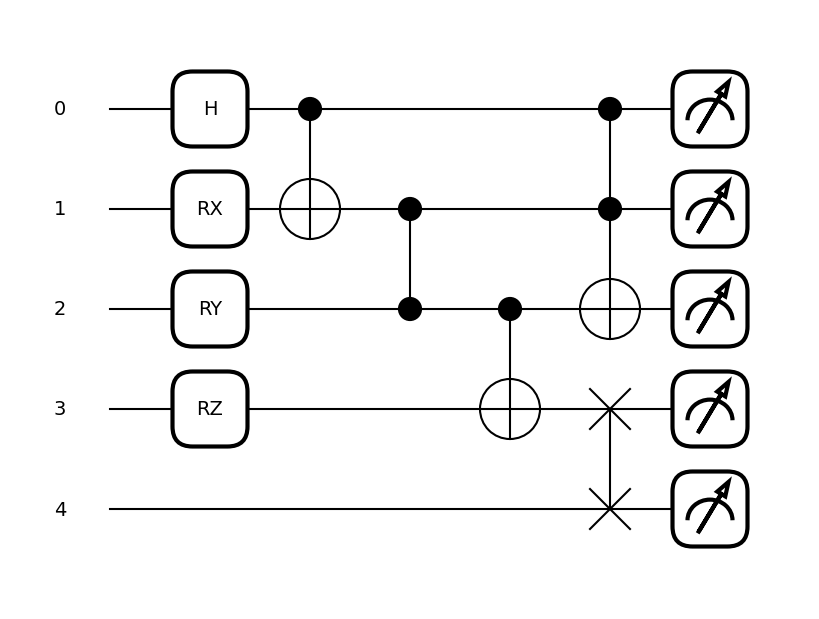

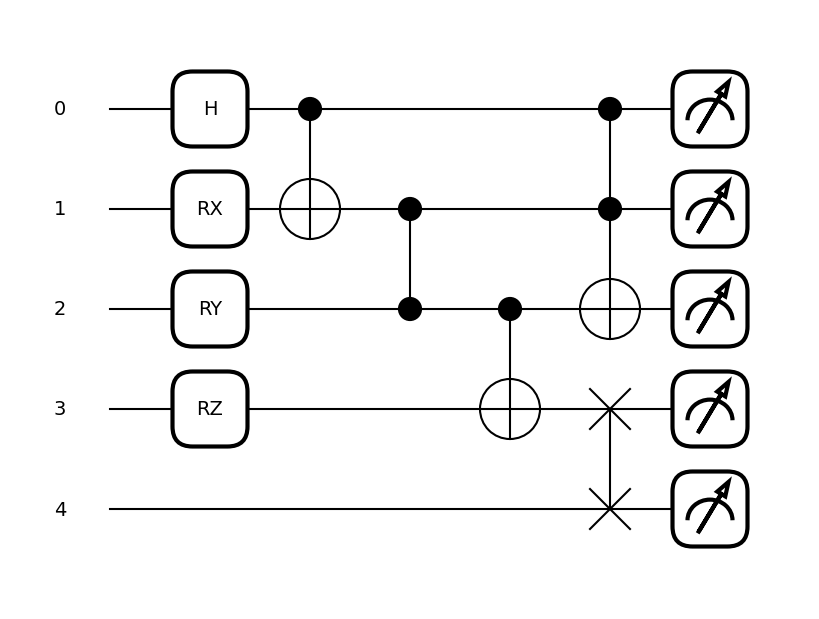

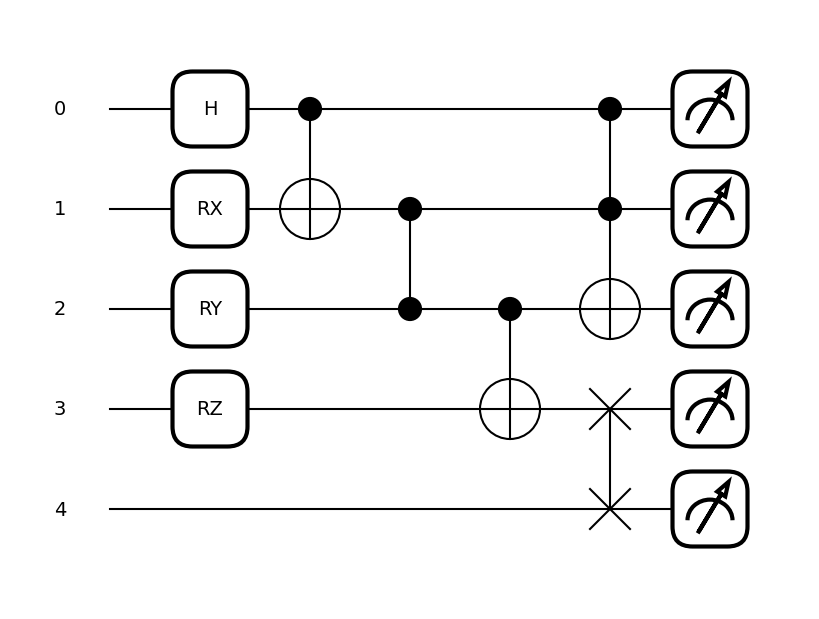

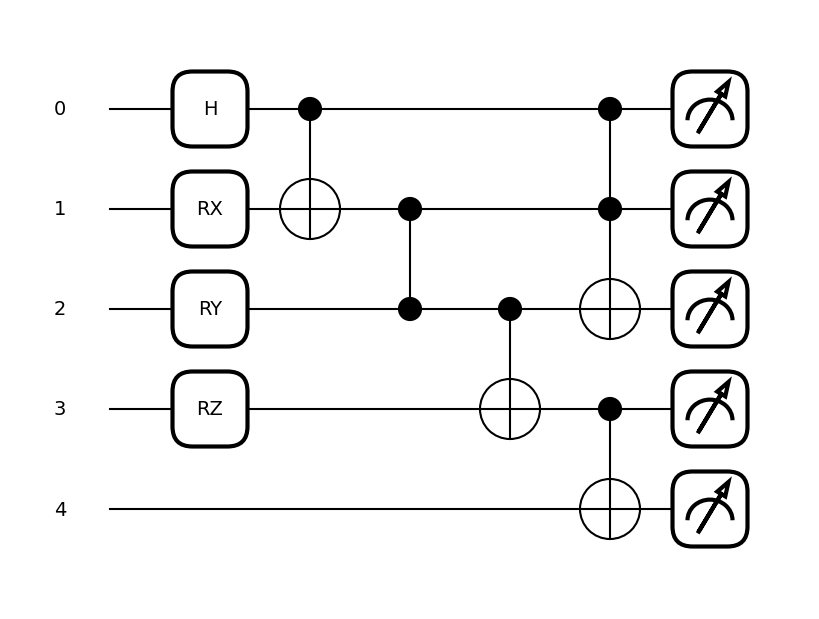

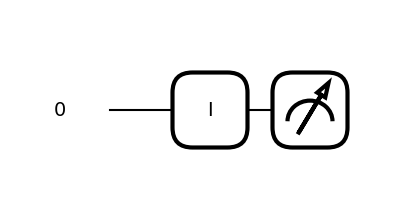

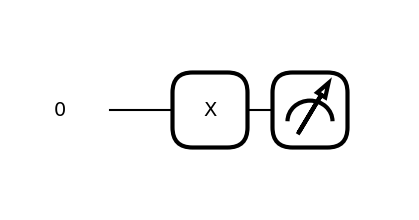

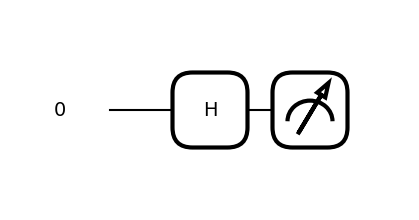

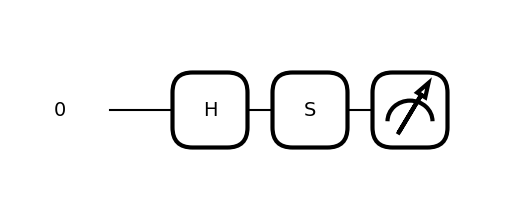

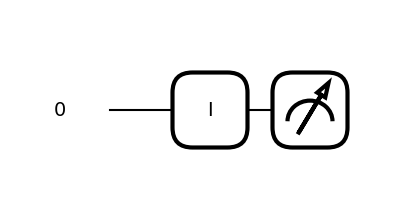

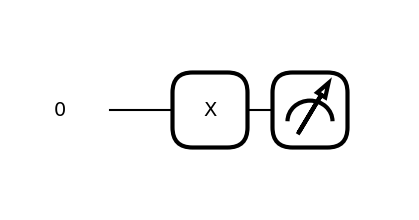

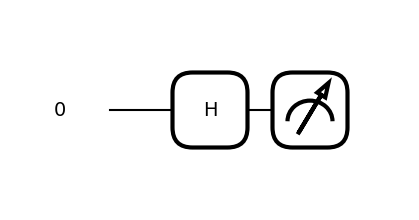

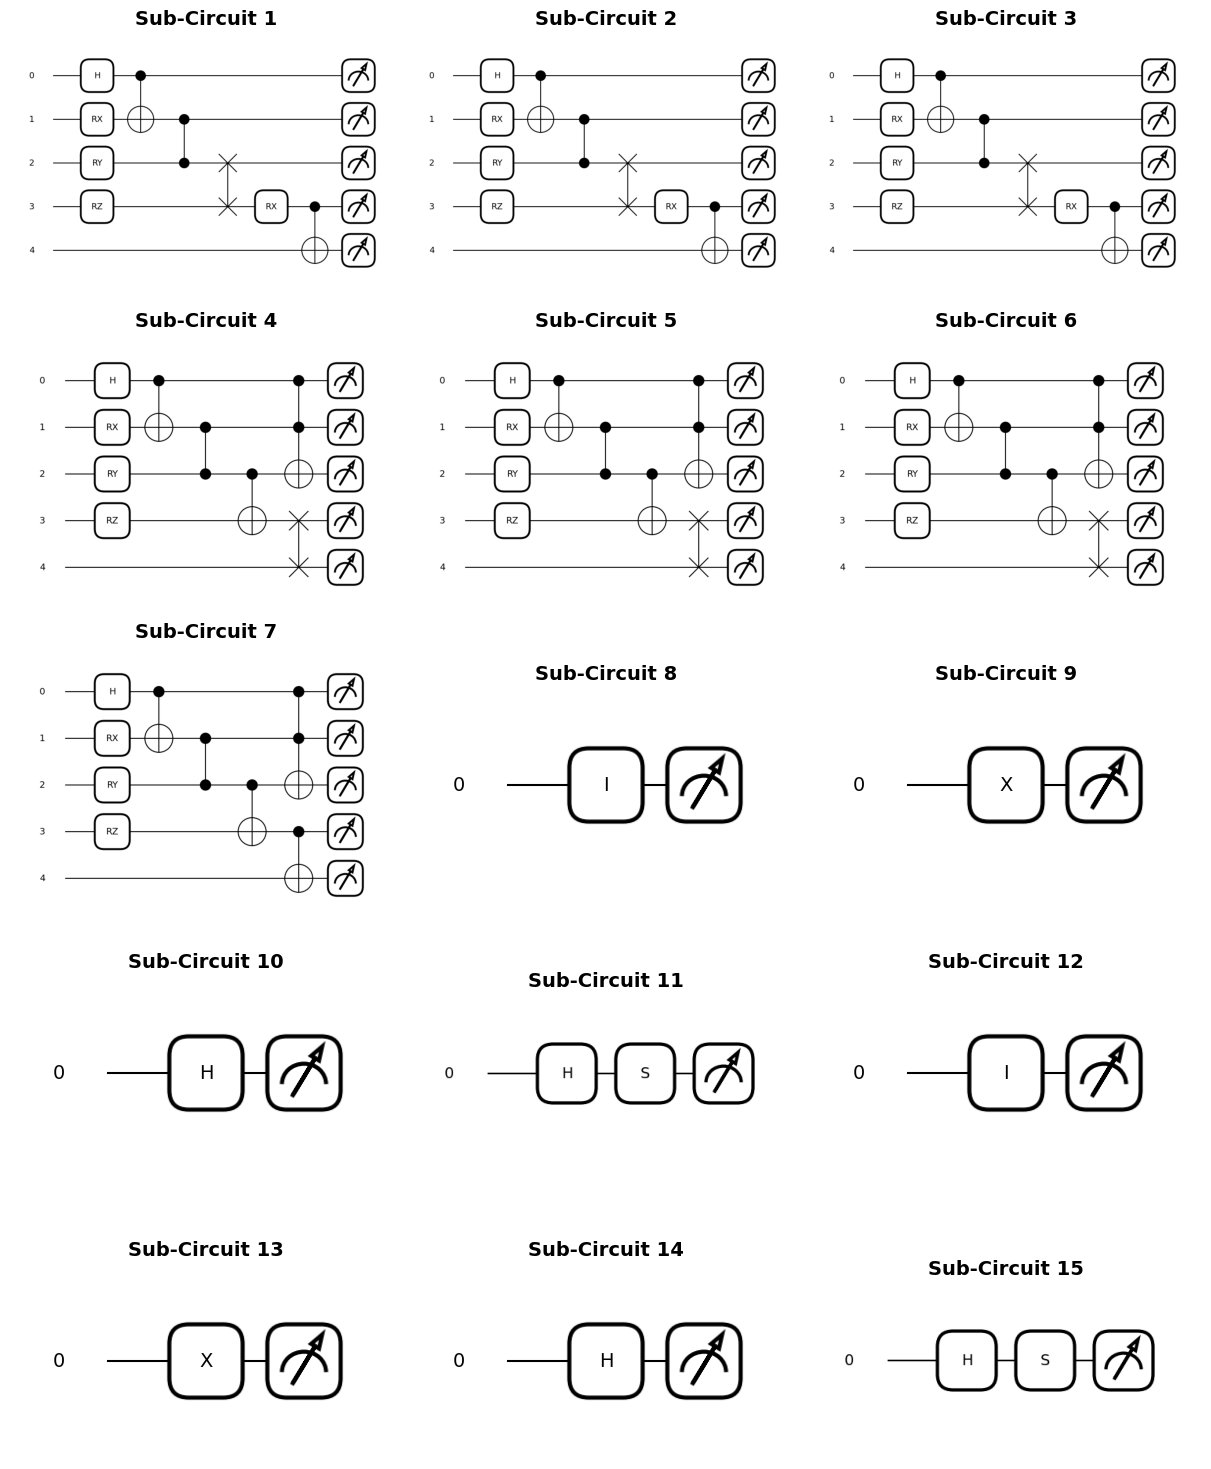

In [ ]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt


def draw_single_page_pdf(figures, titles, filename, cols):
    n_figures = len(figures)
    rows = (n_figures + cols - 1) // cols
    figure, axes = plt.subplots(
        rows, cols, figsize=(cols * 4, rows * 3), constrained_layout=True
    )
    axes = np.array(axes).flatten()
    for ax, (figure, title) in zip(axes, zip(figures, titles)):
        canvas = figure.canvas
        canvas.draw()
        image = np.frombuffer(canvas.tostring_rgb(), dtype="uint8")
        image = image.reshape(canvas.get_width_height()[::-1] + (3,))
        ax.imshow(image)
        ax.axis("off")
        ax.set_title(title, fontsize=14, fontweight="bold")
    # No other axes are needed
    for ax in axes[len(figures) :]:
        ax.axis("off")
    plt.savefig(filename, format="pdf", bbox_inches="tight")
    plt.close(figure)


# Benchmark circuit definition
n_qubits = 15
with qml.tape.QuantumTape() as original_tape:
    qml.Hadamard(wires=0)
    qml.RX(np.random.uniform(0, np.pi), wires=1)
    qml.RY(np.random.uniform(0, np.pi), wires=2)
    qml.RZ(np.random.uniform(0, np.pi), wires=3)
    qml.CNOT(wires=[0, 1])
    qml.CZ(wires=[1, 2])
    qml.SWAP(wires=[2, 3])
    qml.RX(np.random.uniform(0, np.pi), wires=3)
    qml.CNOT(wires=[3, 4])
    qml.WireCut(wires=4)
    qml.Hadamard(wires=5)
    qml.RX(np.random.uniform(0, np.pi), wires=6)
    qml.RY(np.random.uniform(0, np.pi), wires=7)
    qml.RZ(np.random.uniform(0, np.pi), wires=8)
    qml.CNOT(wires=[5, 6])
    qml.CZ(wires=[6, 7])
    qml.CNOT(wires=[7, 8])
    qml.Toffoli(wires=[5, 6, 7])
    qml.SWAP(wires=[8, 9])
    qml.WireCut(wires=9)
    qml.Hadamard(wires=10)
    qml.RX(np.random.uniform(0, np.pi), wires=11)
    qml.RY(np.random.uniform(0, np.pi), wires=12)
    qml.RZ(np.random.uniform(0, np.pi), wires=13)
    qml.CNOT(wires=[10, 11])
    qml.CZ(wires=[11, 12])
    qml.CNOT(wires=[12, 13])
    qml.Toffoli(wires=[10, 11, 12])
    qml.CNOT(wires=[13, 14])
    measurements = [qml.expval(qml.pauli.string_to_pauli_word("Z" * n_qubits))]

qml.drawer.tape_mpl(original_tape)
plt.savefig("benchmark_circuit.pdf", format="pdf", bbox_inches="tight")

dev = qml.device("default.qubit", wires=n_qubits)

# Fragment the circuit
graph = qml.qcut.tape_to_graph(original_tape)
qml.qcut.replace_wire_cut_nodes(graph)
fragments, communication_graph = qml.qcut.fragment_graph(graph)
fragment_tapes = [qml.qcut.graph_to_tape(f) for f in fragments]
fragment_tapes = [
    qml.map_wires(t, dict(zip(t.wires, dev.wires)))[0][0] for t in fragment_tapes
]

# Draw and save all fragments into a combined PDF
draw_single_page_pdf(
    [qml.drawer.tape_mpl(tape)[0] for tape in fragment_tapes],
    [f"Fragment {i + 1}" for i in range(len(fragment_tapes))],
    "benchmark_fragments.pdf",
    cols=2,
)

# Expand circuit fragments
expanded = [qml.qcut.expand_fragment_tape(t) for t in fragment_tapes]
configurations = []
prepare_nodes = []
measure_nodes = []
for t, p, m in expanded:
    configurations.append(t)
    prepare_nodes.append(p)
    measure_nodes.append(m)

# Draw and save all sub-circuits into a combined PDF
sub_tapes = tuple(tape for c in configurations for tape in c)
draw_single_page_pdf(
    [qml.drawer.tape_mpl(t)[0] for t in sub_tapes],
    [f"Sub-Circuit {i + 1}" for i in range(len(sub_tapes))],
    "benchmark_subcircuits.pdf",
    cols=3,
)